In [14]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from tqdm import tqdm
import pandas as pd
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA
https://app.neptune.ai/mohitkhandelwal/vgg/e/VGG-3


1.8.1+cu111


In [3]:
torch.manual_seed(0)


In [20]:
data_dir = "/scratch/mk7711/dast/new_random/dd/"
TRAIN = 'train'
VAL = 'validation'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

batch_size=256
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size,
        shuffle=True, num_workers=10
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 2653 images under train
Loaded 662 images under validation
Loaded 795 images under test
Classes: 
['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


In [5]:
dataset_sizes

{'train': 2653, 'validation': 662, 'test': 795}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


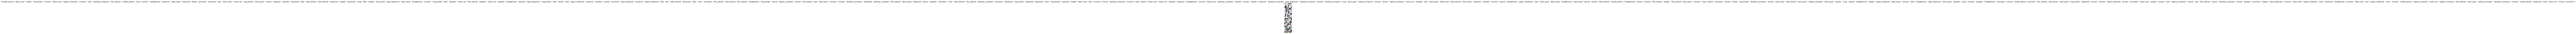

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

In [8]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(tqdm(dataloaders[TEST])):
        #if i % 100 == 0:
         #   print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.to(device),labels.to(device)
                #inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
                
        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        #gc.collect()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    return avg_loss, avg_acc

In [ ]:
#For Pre-trained model
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.require_grad = False

In [9]:
#For non pre-trained model
model = models.vgg16(pretrained=False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names)),nn.Softmax(1) ]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
    
criterion = nn.CrossEntropyLoss()
start_lr=0.00005
weight_decay=0.001
step_size=40
gamma=0.1
epochs=100
optimizer_ft = optim.Adam(model.parameters(), lr=start_lr, betas=(0.5,.999), weight_decay=weight_decay)
#optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.00001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)
if_lr=True
#exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr = 0.001, max_lr = 0.1, gamma=0.1,cycle_momentum=False)

cuda:0


In [11]:
history= []

In [12]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        print("Training Progress: ", flush= True)
        for i, data in enumerate(tqdm(dataloaders[TRAIN])):
            #if i % 100 == 0:
             #   print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            #if i >= train_batches / 2:
             #   break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.to(device), labels.to(device)
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            #print("out",outputs)
            _, preds = torch.max(outputs.data, 1)
            
            #print("Outputs", outputs)
            #print("Preds", preds)
            #print("Labels", labels.data)
            
            #_, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            #print("Acc_train", acc_train)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train/ dataset_sizes[TRAIN]
        avg_acc = acc_train/ dataset_sizes[TRAIN]
        
        model.train(False)
        model.eval()
            
        
        print("Validation Progress: ", flush= True)
        for i, data in enumerate(tqdm(dataloaders[VAL])):
          #  if i % 100 == 0:
                #print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                #inputs, labels = inputs.cuda(),labels.cuda()
                with torch.no_grad():
                    inputs, labels = inputs.to(device),labels.to(device)
                
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            #_, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        history.append([avg_loss, avg_loss_val, avg_acc, avg_acc_val])
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Learning Rate: ", exp_lr_scheduler.get_lr())
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        exp_lr_scheduler.step()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'vgg2-transfer.pt')
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model = train_model(model, criterion, optimizer_ft, num_epochs=epochs)
torch.save(model.state_dict(), 'vgg2-transfer.pt')

Epoch 0/100
----------
Training Progress: 


100%|██████████| 11/11 [00:22<00:00,  2.06s/it]


Validation Progress: 



100%|██████████| 3/3 [00:06<00:00,  2.11s/it]
/home/mk7711/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Epoch 0 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0142
Avg acc (train): 0.0302
Avg loss (val): 0.0156
Avg acc (val): 0.0332
----------

Epoch 1/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]



Epoch 1 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0142
Avg acc (train): 0.0354
Avg loss (val): 0.0155
Avg acc (val): 0.0650
----------

Epoch 2/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 2 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0141
Avg acc (train): 0.0746
Avg loss (val): 0.0156
Avg acc (val): 0.0423
----------

Epoch 3/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]



Epoch 3 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0140
Avg acc (train): 0.0965
Avg loss (val): 0.0153
Avg acc (val): 0.0997
----------

Epoch 4/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 4 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0139
Avg acc (train): 0.1180
Avg loss (val): 0.0153
Avg acc (val): 0.0906
----------

Epoch 5/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.21s/it]



Epoch 5 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0139
Avg acc (train): 0.1266
Avg loss (val): 0.0152
Avg acc (val): 0.1284
----------

Epoch 6/100
----------
Training Progress: 


100%|██████████| 11/11 [00:20<00:00,  1.82s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]



Epoch 6 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0139
Avg acc (train): 0.1289
Avg loss (val): 0.0152
Avg acc (val): 0.1405
----------

Epoch 7/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]



Epoch 7 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0138
Avg acc (train): 0.1504
Avg loss (val): 0.0152
Avg acc (val): 0.1435
----------

Epoch 8/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 8 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0137
Avg acc (train): 0.1681
Avg loss (val): 0.0152
Avg acc (val): 0.1344
----------

Epoch 9/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]



Epoch 9 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0137
Avg acc (train): 0.1730
Avg loss (val): 0.0150
Avg acc (val): 0.1586
----------

Epoch 10/100
----------
Training Progress: 


100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Epoch 10 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0137
Avg acc (train): 0.1775
Avg loss (val): 0.0149
Avg acc (val): 0.1949
----------

Epoch 11/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Epoch 11 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0136
Avg acc (train): 0.1986
Avg loss (val): 0.0149
Avg acc (val): 0.2069
----------

Epoch 12/100
----------
Training Progress: 


100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 12 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0135
Avg acc (train): 0.2262
Avg loss (val): 0.0149
Avg acc (val): 0.2024
----------

Epoch 13/100
----------
Training Progress: 



100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]



Epoch 13 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0135
Avg acc (train): 0.2284
Avg loss (val): 0.0147
Avg acc (val): 0.2417
----------

Epoch 14/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]



Epoch 14 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0134
Avg acc (train): 0.2424
Avg loss (val): 0.0147
Avg acc (val): 0.2477
----------

Epoch 15/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 15 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0134
Avg acc (train): 0.2582
Avg loss (val): 0.0147
Avg acc (val): 0.2447
----------

Epoch 16/100
----------
Training Progress: 



100%|██████████| 11/11 [00:20<00:00,  1.82s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 16 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0134
Avg acc (train): 0.2593
Avg loss (val): 0.0147
Avg acc (val): 0.2341
----------

Epoch 17/100
----------
Training Progress: 



100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 17 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0134
Avg acc (train): 0.2544
Avg loss (val): 0.0148
Avg acc (val): 0.2251
----------

Epoch 18/100
----------
Training Progress: 



100%|██████████| 11/11 [00:20<00:00,  1.84s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]



Epoch 18 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0134
Avg acc (train): 0.2590
Avg loss (val): 0.0147
Avg acc (val): 0.2523
----------

Epoch 19/100
----------
Training Progress: 


100%|██████████| 11/11 [00:20<00:00,  1.82s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 19 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0133
Avg acc (train): 0.2744
Avg loss (val): 0.0147
Avg acc (val): 0.2523
----------

Epoch 20/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 20 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0133
Avg acc (train): 0.2752
Avg loss (val): 0.0147
Avg acc (val): 0.2462
----------

Epoch 21/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.82s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]



Epoch 21 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0132
Avg acc (train): 0.2936
Avg loss (val): 0.0146
Avg acc (val): 0.2734
----------

Epoch 22/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]



Epoch 22 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0132
Avg acc (train): 0.2906
Avg loss (val): 0.0145
Avg acc (val): 0.2749
----------

Epoch 23/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 23 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0132
Avg acc (train): 0.3034
Avg loss (val): 0.0146
Avg acc (val): 0.2719
----------

Epoch 24/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 24 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0131
Avg acc (train): 0.3155
Avg loss (val): 0.0146
Avg acc (val): 0.2644
----------

Epoch 25/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]



Epoch 25 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0131
Avg acc (train): 0.3253
Avg loss (val): 0.0145
Avg acc (val): 0.2855
----------

Epoch 26/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]



Epoch 26 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0131
Avg acc (train): 0.3332
Avg loss (val): 0.0145
Avg acc (val): 0.2915
----------

Epoch 27/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]



Epoch 27 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0130
Avg acc (train): 0.3415
Avg loss (val): 0.0145
Avg acc (val): 0.2946
----------

Epoch 28/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]



Epoch 28 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0130
Avg acc (train): 0.3438
Avg loss (val): 0.0144
Avg acc (val): 0.2961
----------

Epoch 29/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]



Epoch 29 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0130
Avg acc (train): 0.3494
Avg loss (val): 0.0144
Avg acc (val): 0.3097
----------

Epoch 30/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.21s/it]



Epoch 30 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0130
Avg acc (train): 0.3607
Avg loss (val): 0.0144
Avg acc (val): 0.3172
----------

Epoch 31/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]



Epoch 31 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0129
Avg acc (train): 0.3694
Avg loss (val): 0.0143
Avg acc (val): 0.3202
----------

Epoch 32/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 32 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0130
Avg acc (train): 0.3705
Avg loss (val): 0.0144
Avg acc (val): 0.3112
----------

Epoch 33/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 33 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0130
Avg acc (train): 0.3671
Avg loss (val): 0.0144
Avg acc (val): 0.3036
----------

Epoch 34/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 34 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0129
Avg acc (train): 0.3777
Avg loss (val): 0.0147
Avg acc (val): 0.2432
----------

Epoch 35/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 35 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0129
Avg acc (train): 0.3826
Avg loss (val): 0.0143
Avg acc (val): 0.3202
----------

Epoch 36/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 36 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0128
Avg acc (train): 0.4044
Avg loss (val): 0.0144
Avg acc (val): 0.3097
----------

Epoch 37/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 37 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0128
Avg acc (train): 0.3950
Avg loss (val): 0.0143
Avg acc (val): 0.3142
----------

Epoch 38/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]



Epoch 38 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0128
Avg acc (train): 0.3928
Avg loss (val): 0.0144
Avg acc (val): 0.3248
----------

Epoch 39/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.19s/it]



Epoch 39 result: 
Learning Rate:  [5e-05]
Avg loss (train): 0.0128
Avg acc (train): 0.4109
Avg loss (val): 0.0144
Avg acc (val): 0.3338
----------

Epoch 40/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 40 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0127
Avg acc (train): 0.4191
Avg loss (val): 0.0143
Avg acc (val): 0.3278
----------

Epoch 41/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 41 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4248
Avg loss (val): 0.0143
Avg acc (val): 0.3338
----------

Epoch 42/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]



Epoch 42 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4301
Avg loss (val): 0.0143
Avg acc (val): 0.3353
----------

Epoch 43/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 43 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4350
Avg loss (val): 0.0143
Avg acc (val): 0.3338
----------

Epoch 44/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]



Epoch 44 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4342
Avg loss (val): 0.0143
Avg acc (val): 0.3369
----------

Epoch 45/100
----------
Training Progress: 


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]



Epoch 45 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4357
Avg loss (val): 0.0143
Avg acc (val): 0.3399
----------

Epoch 46/100
----------
Training Progress: 


100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Epoch 46 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4369
Avg loss (val): 0.0143
Avg acc (val): 0.3414
----------

Epoch 47/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 47 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0127
Avg acc (train): 0.4369
Avg loss (val): 0.0143
Avg acc (val): 0.3384
----------

Epoch 48/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 48 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4387
Avg loss (val): 0.0142
Avg acc (val): 0.3384
----------

Epoch 49/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 49 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4399
Avg loss (val): 0.0142
Avg acc (val): 0.3414
----------

Epoch 50/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 50 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4425
Avg loss (val): 0.0143
Avg acc (val): 0.3353
----------

Epoch 51/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 51 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4410
Avg loss (val): 0.0143
Avg acc (val): 0.3414
----------

Epoch 52/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 52 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4414
Avg loss (val): 0.0143
Avg acc (val): 0.3414
----------

Epoch 53/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 53 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4421
Avg loss (val): 0.0142
Avg acc (val): 0.3414
----------

Epoch 54/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]



Epoch 54 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4433
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 55/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 55 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4414
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 56/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.21s/it]



Epoch 56 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4489
Avg loss (val): 0.0142
Avg acc (val): 0.3489
----------

Epoch 57/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 57 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4470
Avg loss (val): 0.0142
Avg acc (val): 0.3474
----------

Epoch 58/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 58 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4474
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 59/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 59 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4478
Avg loss (val): 0.0142
Avg acc (val): 0.3474
----------

Epoch 60/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 60 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4485
Avg loss (val): 0.0142
Avg acc (val): 0.3474
----------

Epoch 61/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]



Epoch 61 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4497
Avg loss (val): 0.0142
Avg acc (val): 0.3505
----------

Epoch 62/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 62 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4516
Avg loss (val): 0.0142
Avg acc (val): 0.3489
----------

Epoch 63/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 63 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4516
Avg loss (val): 0.0142
Avg acc (val): 0.3505
----------

Epoch 64/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 64 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4523
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 65/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 65 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4508
Avg loss (val): 0.0142
Avg acc (val): 0.3505
----------

Epoch 66/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 66 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4516
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 67/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 67 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4542
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 68/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 68 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4553
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 69/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 69 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4527
Avg loss (val): 0.0142
Avg acc (val): 0.3489
----------

Epoch 70/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 70 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4538
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 71/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 71 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4546
Avg loss (val): 0.0142
Avg acc (val): 0.3489
----------

Epoch 72/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 72 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4553
Avg loss (val): 0.0142
Avg acc (val): 0.3505
----------

Epoch 73/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]



Epoch 73 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4568
Avg loss (val): 0.0142
Avg acc (val): 0.3520
----------

Epoch 74/100
----------
Training Progress: 


100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 74 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4557
Avg loss (val): 0.0142
Avg acc (val): 0.3474
----------

Epoch 75/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 75 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4568
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 76/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 76 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4576
Avg loss (val): 0.0142
Avg acc (val): 0.3505
----------

Epoch 77/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 77 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4568
Avg loss (val): 0.0142
Avg acc (val): 0.3489
----------

Epoch 78/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 78 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4580
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 79/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 79 result: 
Learning Rate:  [5e-06]
Avg loss (train): 0.0126
Avg acc (train): 0.4583
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 80/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 80 result: 
Learning Rate:  [5.000000000000001e-08]
Avg loss (train): 0.0126
Avg acc (train): 0.4587
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 81/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 81 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4591
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 82/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 82 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4599
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 83/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 83 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4576
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 84/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 84 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4591
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 85/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch 85 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4591
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 86/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 86 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4599
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 87/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 87 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4591
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 88/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 88 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4587
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 89/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 89 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4599
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 90/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 90 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4599
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 91/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 91 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4610
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 92/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 92 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4614
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 93/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 93 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4606
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 94/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 94 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4599
Avg loss (val): 0.0142
Avg acc (val): 0.3459
----------

Epoch 95/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 95 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4595
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 96/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 96 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4595
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 97/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 97 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4606
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 98/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch 98 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0126
Avg acc (train): 0.4587
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------

Epoch 99/100
----------
Training Progress: 



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Validation Progress: 



100%|██████████| 3/3 [00:03<00:00,  1.26s/it]



Epoch 99 result: 
Learning Rate:  [5.000000000000001e-07]
Avg loss (train): 0.0125
Avg acc (train): 0.4606
Avg loss (val): 0.0142
Avg acc (val): 0.3444
----------


Training completed in 39m 51s
Best acc: 0.3520


In [15]:
history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])

Text(0.5, 1.0, 'Training and Validation Losses')

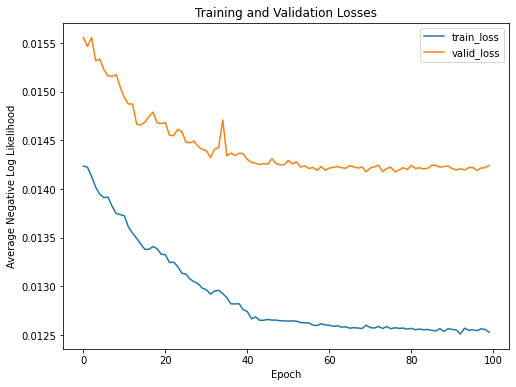

In [16]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

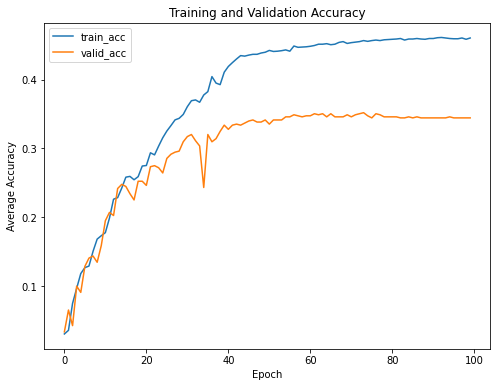

In [17]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
         history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [18]:
test_loss, test_acc= eval_model(model, criterion)

  0%|          | 0/4 [00:00<?, ?it/s]

Evaluating model
----------


100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


Evaluation completed in 0m 7s
Avg loss (test): 0.0169
Avg acc (test): 0.1308
----------
